In [ ]:
import os, glob
from pathlib import Path
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# River (install with: pip install river)
from river import drift as river_drift
# from river import linear_model, preprocessing, metrics   # ← optional online learner

In [ ]:
def load_individual_station_files(data_directory: str) -> pd.DataFrame:
    """Read all PRSA_Data_*.csv files, add a ``station`` column, and concatenate."""
    csv_files = glob.glob(os.path.join(data_directory, "PRSA_Data_*.csv"))
    if not csv_files:
        raise FileNotFoundError(
            f"No CSV files found in {data_directory}. "
            "Did you unzip the original PRSA2017_Data_20130301-20170228.zip?"
        )
    all_data = []
    for file in csv_files:
        parts = Path(file).stem.split('_')
        station_name = "_".join(parts[2:-1]) if len(parts) > 3 else parts[-2]
        print(f"Loading {file} (station={station_name})...")
        df = pd.read_csv(file)
        if "station" not in df.columns:
            df["station"] = station_name
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)



In [9]:
# ----------------------------------------------------------------------
# 2 PRE‑PROCESSING
# ----------------------------------------------------------------------
def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'PM2.5': 'PM2_5', 'PM10': 'PM10', 'SO2': 'SO2', 'NO2': 'NO2',
        'CO': 'CO', 'O3': 'O3', 'TEMP': 'TEMP', 'PRES': 'PRES',
        'DEWP': 'DEWP', 'RAIN': 'RAIN', 'wd': 'wd', 'WSPM': 'WSPM',
        'station': 'station', 'year': 'year', 'month': 'month',
        'day': 'day', 'hour': 'hour'
    }
    keep = [c for c in mapping if c in df.columns]
    return df[keep].rename(columns=mapping)


def _build_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    if not {'year', 'month', 'day', 'hour'}.issubset(df.columns):
        raise ValueError("Missing year/month/day/hour columns")
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    return df.sort_values('datetime').set_index('datetime', drop=True)


def _coerce_numeric(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df


def _encode_wind_direction(df: pd.DataFrame) -> pd.DataFrame:
    compass = {
        'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90,
        'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
        'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
        'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
    }
    if 'wd' in df.columns:
        wd_deg = df['wd'].map(compass)
        if wd_deg.isna().any():
            wd_deg = df['wd'].str.upper().map(compass)
        df['wd_deg'] = wd_deg
        rad = np.deg2rad(df['wd_deg'])
        df['wd_sin'] = np.sin(rad)
        df['wd_cos'] = np.cos(rad)
    return df


def _add_time_cyclic_features(df: pd.DataFrame) -> pd.DataFrame:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']  = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']  = np.cos(2*np.pi*df['dayofweek']/7)
    df['mon_sin']  = np.sin(2*np.pi*df['month']/12)
    df['mon_cos']  = np.cos(2*np.pi*df['month']/12)
    return df


def _hampel_filter_1d(x: pd.Series, window: int = 13, n_sigmas: float = 3.0) -> pd.Series:
    if x.isna().all():
        return x
    rolling_med = x.rolling(window, center=True).median()
    mad = (np.abs(x - rolling_med)).rolling(window, center=True).median()
    k = 1.4826
    threshold = n_sigmas * k * mad
    outlier_mask = np.abs(x - rolling_med) > threshold
    x_clean = x.copy()
    x_clean[outlier_mask] = rolling_med[outlier_mask]
    return x_clean


def preprocess_beijing_data(
    df: pd.DataFrame,
    *,
    remove_duplicates: bool = True,
    interpolate_numeric: bool = True,
    outlier_method: str = "hampel",      # "hampel" or None
    outlier_window: int = 13,
    outlier_sigmas: float = 3.0,
    make_daily: bool = True
):
    """Returns (hourly_df, daily_df).  ``daily_df`` is a mean‑per‑day aggregation."""
    df = _normalize_columns(df)

    if 'station' not in df.columns:
        raise ValueError("Column 'station' is required.")

    df = _build_datetime_index(df)

    # --------------------------------------------------------------
    #   Duplicates
    # --------------------------------------------------------------
    if remove_duplicates:
        df = df[~df.index.duplicated(keep="first")]

    # --------------------------------------------------------------
    #   Numeric columns & interpolation
    # --------------------------------------------------------------
    pollutant_cols = [c for c in ['PM2_5','PM10','SO2','NO2','CO','O3'] if c in df.columns]
    weather_cols   = [c for c in ['TEMP','PRES','DEWP','RAIN','WSPM'] if c in df.columns]
    num_cols = pollutant_cols + weather_cols

    df = _coerce_numeric(df, num_cols)

    # Drop rows where *all* pollutants are missing (keep weather‑only rows)
    if pollutant_cols:
        df = df.dropna(subset=pollutant_cols, how='all')

    if interpolate_numeric and num_cols:
        df = (
            df.sort_index()
            .groupby('station', group_keys=False)
            .apply(lambda g: g.assign(**{
                c: g[c].interpolate(method='time', limit_direction='both')
                for c in num_cols
            }))
        )
        df[num_cols] = (
            df[num_cols]
            .groupby(df['station']).ffill()
            .groupby(df['station']).bfill()
        )

    # --------------------------------------------------------------
    #   Categorical wind direction
    # --------------------------------------------------------------
    if 'wd' in df.columns:
        df['wd'] = df.groupby('station')['wd'].ffill().groupby(df['station']).bfill()

    # --------------------------------------------------------------
    #  Feature engineering
    # --------------------------------------------------------------
    df = _encode_wind_direction(df)
    df = _add_time_cyclic_features(df)

    # --------------------------------------------------------------
    #  Outlier correction (Hampel) – per station / per column
    # --------------------------------------------------------------
    if outlier_method == "hampel" and num_cols:
        def _clean(g):
            for c in num_cols:
                g[c] = _hampel_filter_1d(g[c],
                                         window=outlier_window,
                                         n_sigmas=outlier_sigmas)
            return g
        df = df.groupby('station', group_keys=False).apply(_clean)

    # --------------------------------------------------------------
    #  Daily aggregation 
    # --------------------------------------------------------------
    daily_df = None
    if make_daily:
        numeric = df[num_cols + [c for c in df.columns if c.endswith(('_sin','_cos'))]].copy()
        daily_df = (
            numeric
            .groupby(df['station'])
            .resample('D')
            .mean(numeric_only=True)
            .reset_index()
            .set_index('datetime')
            .sort_index()
        )

    df = df.sort_index()
    return df, daily_df


In [ ]:
# ----------------------------------------------------------------------
# DRIFT DETECTION (streaming) – overflow‑safe version
# ----------------------------------------------------------------------
def _drift_flag(det) -> bool:
    """River detectors expose the flag under different names."""
    if hasattr(det, "drift_detected"):
        return det.drift_detected          # ADWIN
    if hasattr(det, "change_detected"):
        return det.change_detected          # DDM / EDDM
    return False


def init_detectors(detector_cls=river_drift.ADWIN, **det_kwargs):
    """Defaultdict that creates a fresh detector for each new station."""
    return defaultdict(lambda: detector_cls(**det_kwargs))


def stream_with_drift(
    daily_df: pd.DataFrame,
    target: str = "PM2_5",
    delta: float = 0.002,
    drift_cooldown: pd.Timedelta = pd.Timedelta(days=30),
    reset_on_drift: bool = False,
):
    """
    Pure drift detection (no online model). Returns a dict:
        { station : {"change_points": [...], "final_mae": None} }
    """
    detectors = init_detectors(river_drift.ADWIN, delta=delta)
    # optional online‑learning structures – keep commented unless you need them
    # models     = defaultdict(lambda: preprocessing.StandardScaler() | linear_model.LinearRegression())
    # mae_metric = defaultdict(metrics.MAE)

    # Use NaT (Not‑a‑Time) as the sentinel – avoids overflow when subtracting
    last_change = defaultdict(lambda: pd.NaT)

    for ts, row in daily_df.iterrows():      # index (Timestamp), row (Series)
        station = row["station"]
        y = row[target]

        # --------------------------------------------------------------
        #  Drift detection
        # --------------------------------------------------------------
        det = detectors[station]
        det.update(y)

        if _drift_flag(det):
            # First detection for this station OR far enough from the previous one
            if pd.isna(last_change[station]) or (ts - last_change[station] > drift_cooldown):
                print(f"[{ts.date()}] Drift detected @ station `{station}`")
                last_change[station] = ts

                # ------------------------------------------------------
                # Optional: reset an online model when a drift occurs
                # ------------------------------------------------------
                # if reset_on_drift:
                #     models[station] = preprocessing.StandardScaler() | linear_model.LinearRegression()
                #     mae_metric[station] = metrics.MAE()

        # --------------------------------------------------------------
        # (Optional) online learning – keep commented
        # --------------------------------------------------------------
        # if pd.notna(y) and reset_on_drift:
        #     x = row.drop([target, "station"]).to_dict()
        #     model = models[station]
        #     model = model.learn_one(x, y)
        #     models[station] = model
        #     y_pred = model.predict_one(x)
        #     mae_metric[station].update(y_true=y, y_pred=y_pred)

    # ------------------------------------------------------------------
    # Assemble results
    # ------------------------------------------------------------------
    results = {}
    for st in detectors.keys():
        cps = [cp for cp in daily_df.index
               if cp in last_change.values() and (pd.isna(last_change[st]) or cp >= last_change[st] - drift_cooldown)]
        results[st] = {
            "change_points": sorted(set(cps)),
            "final_mae": None   # None because we are not using the online model
        }
    return results


# ----------------------------------------------------------------------
#  VISUALISATION helper
# ----------------------------------------------------------------------
def plot_series_with_drifts(series: pd.Series,
                           change_points: list,
                           title: str = ""):
    plt.figure(figsize=(12, 4))
    plt.plot(series, label="Series")
    for cp in change_points:
        plt.axvline(cp, color="red", linestyle="--", lw=1, label="Drift")
    plt.title(title)
    plt.legend()
    plt.show()


# ----------------------------------------------------------------------
# FILL‑TARGET helper (you asked about it)
# ----------------------------------------------------------------------
def fill_target(series: pd.Series, window: int = 3) -> pd.Series:
    """
    Rolling‑mean (window centred on each missing point)  
    Forward‑fill  
    Backward‑fill (for any leading gaps)  

    Returns a fully‑filled Series.
    """
    filled = series.copy()
    rolling_mean = filled.rolling(window=window,
                                 min_periods=1,
                                 center=True).mean()
    filled = filled.fillna(rolling_mean)
    filled = filled.ffill()
    filled = filled.bfill()
    return filled



Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv (station=Gucheng)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv (station=Huairou)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Tiantan_20130301-20170228.csv (station=Tiantan)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv (station=Changping)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv (station=Guanyuan)...
Loading /Users/aazab/Partition_A/Master/Poland Master/master/dat

/var/folders/t6/7l2lh46j449d_kcvhyjpplj40000gp/T/ipykernel_87022/883281411.py:115: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(**{
/var/folders/t6/7l2lh46j449d_kcvhyjpplj40000gp/T/ipykernel_87022/883281411.py:148: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('station', group_keys=False).apply(_clean)



Hourly shape: (34649, 27)
Daily shape : (17528, 20)

Running streaming drift detection (ADWIN)…
[2014-03-19] Drift detected @ station `Wanshouxigong`
[2014-03-19] Drift detected @ station `Dingling`
[2014-03-19] Drift detected @ station `Huairou`
[2014-03-19] Drift detected @ station `Dongsi`
[2014-03-20] Drift detected @ station `Guanyuan`
[2014-04-21] Drift detected @ station `Changping`
[2014-06-23] Drift detected @ station `Huairou`
[2014-09-27] Drift detected @ station `Dingling`
[2014-10-29] Drift detected @ station `Aotizhongxin`
[2014-10-29] Drift detected @ station `Nongzhanguan`
[2014-10-30] Drift detected @ station `Guanyuan`
[2014-10-30] Drift detected @ station `Changping`
[2014-11-30] Drift detected @ station `Gucheng`
[2014-11-30] Drift detected @ station `Wanshouxigong`
[2015-06-10] Drift detected @ station `Dingling`
[2015-07-12] Drift detected @ station `Nongzhanguan`
[2015-09-14] Drift detected @ station `Shunyi`
[2015-09-14] Drift detected @ station `Nongzhanguan`


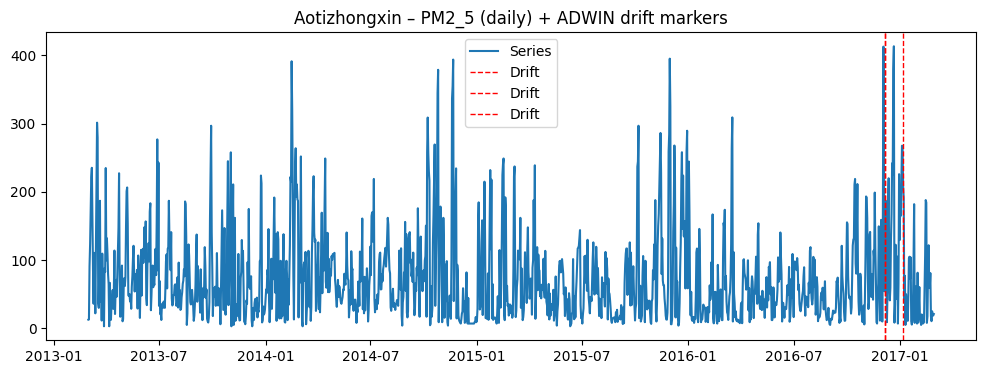

/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre


Baseline SARIMAX MAE on 2017 hold‑out: 76.4057


/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/aazab/Partition_A/Master/Poland Master/master/code/master_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: Co


SARIMAX models per regime:
 Regime 1: 2013-03-01 → 2016-12-05, AIC = 14529.51
 Regime 3: 2016-12-06 → 2017-01-06, AIC = 31.56
 Regime 4: 2017-01-06 → 2017-02-28, AIC = 1143.67


In [10]:
# ----------------------------------------------------------------------
# MAIN
# ----------------------------------------------------------------------
def main():
    # --------------------------------------------------------------
    # 5.1  Load raw CSVs
    # --------------------------------------------------------------
    data_dir = "/Users/aazab/Partition_A/Master/Poland Master/master/data/Beijing Multi-Site Air Quality/PRSA_Data_20130301-20170228"
    raw_df = load_individual_station_files(data_dir)
    print(f"\nRaw shape: {raw_df.shape}")

    # --------------------------------------------------------------
    # 5.2  Pre‑process → hourly + daily dataframes
    # --------------------------------------------------------------
    hourly_df, daily_df = preprocess_beijing_data(
        raw_df,
        remove_duplicates=True,
        interpolate_numeric=True,
        outlier_method="hampel",
        outlier_window=13,
        outlier_sigmas=3.0,
        make_daily=True,
    )
    print(f"\nHourly shape: {hourly_df.shape}")
    print(f"Daily shape : {daily_df.shape}")

    # --------------------------------------------------------------
    # *** NEW: fill missing values in the target (and optionally others) ***
    # --------------------------------------------------------------
    # Fill PM2_5 per station using a 7‑day rolling window.
    daily_df['PM2_5'] = (
        daily_df
        .groupby('station')['PM2_5']
        .transform(lambda s: fill_target(s, window=7))
    )
    # (Optional) fill other numeric columns the same way
    for col in ['TEMP', 'WSPM', 'wd_sin', 'wd_cos']:
        if col in daily_df.columns:
            daily_df[col] = (
                daily_df
                .groupby('station')[col]
                .transform(lambda s: fill_target(s, window=5))
            )

    # --------------------------------------------------------------
    # 5.3  Stream drift detection (ADWIN) – pure change‑point search
    # --------------------------------------------------------------
    print("\nRunning streaming drift detection (ADWIN)…")
    drift_info = stream_with_drift(
        daily_df,
        target="PM2_5",
        delta=0.002,                 # reduce e.g. 0.001 for a more sensitive detector
        drift_cooldown=pd.Timedelta(days=30),
        reset_on_drift=False        # keep False → only change points
    )

    # --------------------------------------------------------------
    # 5.4  Pick a station, show drift points & plot
    # --------------------------------------------------------------
    station = "Aotizhongxin"
    cp_list = drift_info[station]["change_points"]
    print(f"\nDetected {len(cp_list)} drift points for station `{station}`:")
    for cp in cp_list:
        print("  –", cp.date())

    series = daily_df[daily_df["station"] == station]["PM2_5"]
    plot_series_with_drifts(series, cp_list,
                            title=f"{station} – PM2_5 (daily) + ADWIN drift markers")

    # --------------------------------------------------------------
    # 5.5  Baseline SARIMAX on the whole series (train / test split)
    # --------------------------------------------------------------
    train = series[:'2016-12-31']      # already fully filled
    test  = series['2017-01-01':]     # already fully filled

    if test.empty:
        print("\n⚠️  Test set is empty – cannot compute MAE.")
    else:
        sarimax = SARIMAX(
            train,
            order=(2, 1, 2),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fit = sarimax.fit(disp=False)

        pred = fit.get_forecast(steps=len(test)).predicted_mean
        # Forecast may still contain NaNs in pathological cases – drop them
        pred = pred.dropna()
        mae = mean_absolute_error(test.loc[pred.index], pred)
        print(f"\nBaseline SARIMAX MAE on 2017 hold‑out: {mae:.4f}")

    # --------------------------------------------------------------
    # 5.6  Fit a SARIMAX model *per regime* defined by drift points
    # --------------------------------------------------------------
    def fit_sarimax_per_regime(daily_df, station, target, change_points,
                           order=(2,1,2), seasonal_order=(1,1,1,12)):
        """
        Fit a separate SARIMAX model to each regime delimited by ``change_points``.

        Parameters
        ----------
        daily_df        : DataFrame (already daily‑aggregated, indexed by datetime)
        station         : str   – the station you want to model
        target          : str   – column name (e.g., "PM2_5")
        change_points   : list of Timestamp – drift timestamps for this station
        order, seasonal_order : SARIMAX orders

        Returns
        -------
        List of dicts, each containing:
            {"regime_id": int,
            "start": Timestamp,
            "end": Timestamp,
            "aic": float,
            "model": fitted SARIMAX result}
        """
        # Build regime boundaries (add start & end of the whole series)
        bounds = [daily_df.index.min()] + sorted(change_points) + [daily_df.index.max()]
        regimes = [(bounds[i], bounds[i + 1]) for i in range(len(bounds) - 1)]

        models = []
        for i, (start, end) in enumerate(regimes, 1):
            # ------------------------------------------------------------------
            #  Extract the *station‑specific* slice for this regime
            # ------------------------------------------------------------------
            seg = (
                daily_df[daily_df["station"] == station]   # station filter
                .loc[start:end, target]                    # time slice + column
                .dropna()                                  # safety – no NaNs
            )

            # ------------------------------------------------------------------
            # Skip regimes that are too short (SARIMAX needs a decent sample)
            # ------------------------------------------------------------------
            if len(seg) < 30:        # you can tune this threshold
                continue

            # ------------------------------------------------------------------
            # Fit SARIMAX
            # ------------------------------------------------------------------
            model = SARIMAX(
                seg,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fit = model.fit(disp=False)

            models.append({
                "regime_id": i,
                "start": start,
                "end": end,
                "aic": fit.aic,
                "model": fit
            })
        return models


    regime_models = fit_sarimax_per_regime(daily_df, station, "PM2_5", cp_list)
    print("\nSARIMAX models per regime:")
    for r in regime_models:
        print(
            f" Regime {r['regime_id']}: {r['start'].date()} → {r['end'].date()}, "
            f"AIC = {r['aic']:.2f}"
        )

    return hourly_df, daily_df, drift_info, regime_models


if __name__ == "__main__":
    hourly_df, daily_df, drift_info, regime_models = main()
